<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

Mounted at /content/drive


In [2]:
df = pd.read_csv('drive/MyDrive/ML_course/tweet_sentiment_train.csv/train.csv')

In [3]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
df.dropna(inplace=True)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [6]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


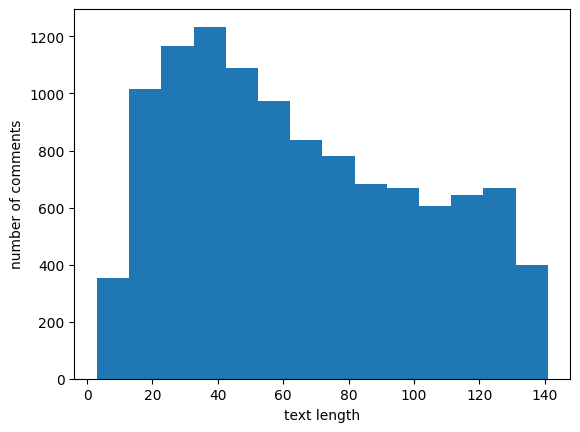

In [7]:
plt.hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
plt.xlabel('text length')
plt.ylabel('number of comments');

Text(0.5, 1.0, 'negative')

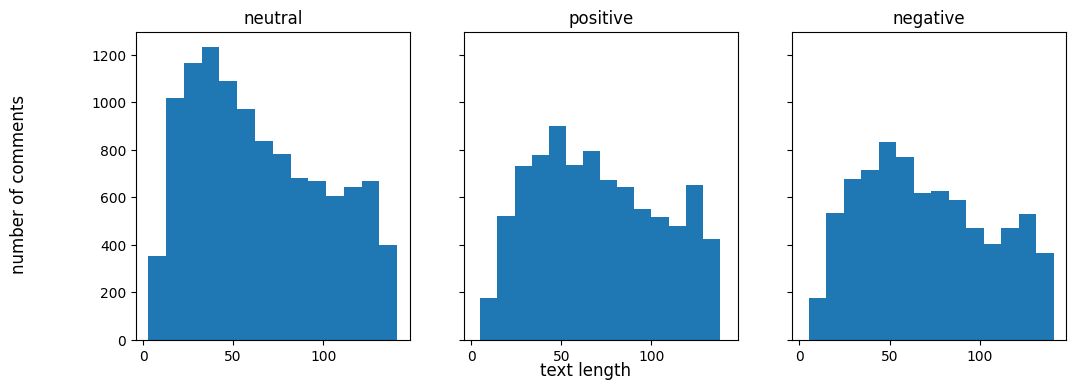

In [8]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True, sharey=True)
fig.supxlabel('text length')
fig.supylabel('number of comments')
ax[0].hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
ax[0].set_title('neutral')
ax[1].hist(df[df.sentiment=='positive']['text'].str.len(), bins=14)
ax[1].set_title('positive')
ax[2].hist(df[df.sentiment=='negative']['text'].str.len(), bins=14)
ax[2].set_title('negative')

Найбільше коментарів, що містять близько 40 символів, розподіл зміщений вліво. Якщо окремо дивитись по типу коментарів, то видно, для всіх груп розподіл подібний.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [9]:
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [10]:
import nltk

In [11]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
detector=PunktSentenceTokenizer()

In [13]:
vect=CountVectorizer()
vect_fit=vect.fit(df.text)

In [14]:
vect.get_feature_names_out().shape

(26439,)

In [15]:
vectors=vect.transform(df.text)

In [16]:
stemmer=SnowballStemmer(language='english')

In [17]:
nltk.download('stopwords')
english_stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [65]:
def tokenize(text):
  return [stemmer.stem(word) for word in word_tokenize(text)]

In [66]:
vectorizer=CountVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=1000)


In [67]:
vectorizer.fit(df['selected_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7d82a8e05760>)

In [68]:
inputs=vectorizer.transform(df['selected_text'])

In [69]:
inputs.shape

(27480, 1000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [23]:
target=df.iloc[:,-1].name

In [70]:
train_idx, test_idx=train_test_split(range(inputs.shape[0]), test_size=0.3, random_state=42)

In [71]:
X_train_bow=inputs[train_idx]
X_test_bow=inputs[test_idx]
y_train=df.iloc[train_idx, -1]
y_test=df.iloc[test_idx, -1]

In [73]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [74]:
logreg.fit(X_train_bow, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', solver='saga')

In [76]:
y_pred_train=logreg.predict(X_train_bow)

In [77]:
accuracy_score(y_train, y_pred_train)

0.7898731545019755

In [78]:
f1_score(y_train, y_pred_train, average='weighted')

0.7893092827337765

In [79]:
confusion_matrix(y_train, y_pred_train)

array([[3968, 1077,  380],
       [ 649, 6642,  483],
       [ 640,  813, 4584]])

In [80]:
y_pred=logreg.predict(X_test_bow)

In [81]:
accuracy_score(y_test, y_pred)

0.7794759825327511

In [82]:
f1_score(y_test, y_pred, average='weighted')

0.7791049035740154

In [83]:
confusion_matrix(y_test, y_pred)

array([[1709,  464,  183],
       [ 326, 2792,  225],
       [ 284,  336, 1925]])

In [89]:
tree=DecisionTreeClassifier(splitter='best', random_state=42, max_depth=1000)

In [90]:
tree.fit(X_train_bow, y_train)
tree_pred=tree.predict(X_test_bow)

In [91]:
accuracy_score(y_test, tree_pred)

0.7106986899563319

In [92]:
f1_score(y_test, tree_pred, average='weighted')

0.711744282289175

In [93]:
confusion_matrix(y_test, y_pred)

array([[1709,  464,  183],
       [ 326, 2792,  225],
       [ 284,  336, 1925]])

In [42]:
import numpy as np

In [43]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred, name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_bow), columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_bow), axis=1), name='max_proba')], axis=1)

In [44]:
pred_test

,sentiment,pred_class,neg,neutr,pos,max_proba
0,positive,positive,0.170670,0.264955,0.564374,0.564374
1,negative,neutral,0.305384,0.489813,0.204803,0.489813
2,neutral,neutral,0.212728,0.524534,0.262738,0.524534
3,positive,neutral,0.168060,0.488986,0.342954,0.488986
4,neutral,neutral,0.300724,0.419427,0.279849,0.419427
...,...,...,...,...,...,...
8239,positive,positive,0.000788,0.005613,0.993599,0.993599
8240,neutral,neutral,0.290125,0.613233,0.096642,0.613233
8241,positive,positive,0.017540,0.042603,0.939857,0.939857
8242,negative,negative,0.717907,0.214733,0.067360,0.717907


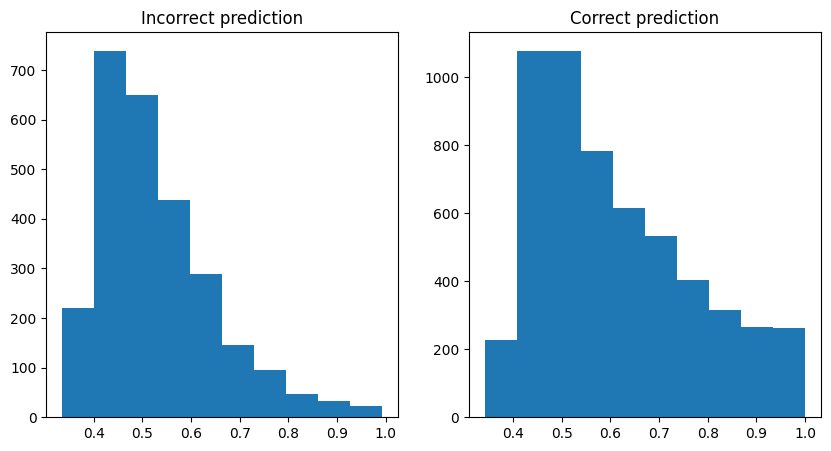

In [45]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

Значення метрики f1 на тестових даних 67,5%. Модель не дуже точна. З матриці видно, що модель багато зразків невірно відносить до нейтрального класу. З графіків розподілу ймовірностей видно, що на неправильно передбачених зразках модель не дуже впевнена і багато ймовірностей лежить в діапазоні 0.34-0.5, тоді як менше значень в дапазоні 0.7-1.0. Хоча і серед правильних передбачень велика к-сть зразків з ймовірністю до 0.5.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [46]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=vectorizer.get_feature_names_out(), columns=['imp'])

In [47]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [48]:
valuable_words

,index,imp,index,imp
0,love,-1.162634,sad,1.387776
1,thank,-1.060433,miss,1.290312
2,hope,-0.773245,sorri,1.165592
3,awesom,-0.761849,suck,1.130321
4,great,-0.734019,hate,1.102810
5,good,-0.702831,bore,0.944903
6,happi,-0.690478,hurt,0.902746
7,nice,-0.681006,sick,0.870378
8,lol,-0.563001,bad,0.862444
9,better,-0.524681,tire,0.692059


Загалом, перелік важливих слів виглядає логічно.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [94]:
tfidf=TfidfVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=1000)

In [126]:
english_stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [95]:
tfidf.fit(df['selected_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7d82a8e05760>)

In [96]:
input_tfidf=tfidf.transform(df['selected_text'])
# X_test_tfidf=tfidf.transform(X_test_tfidf)

In [97]:
X_train_tfidf=input_tfidf[train_idx]
X_test_tfidf=input_tfidf[test_idx]

In [98]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [100]:
logreg.fit(X_train_tfidf, y_train)
pred_tfidf=logreg.predict(X_test_tfidf)
proba_tfidf=logreg.predict_proba(X_test_tfidf)

In [101]:
accuracy_score(y_test, pred_tfidf)

0.8003396409509946

In [102]:
f1_score(y_test, pred_tfidf, average='weighted')

0.8004479360823052

In [103]:
confusion_matrix(y_test, pred_tfidf)

array([[1803,  386,  167],
       [ 333, 2797,  213],
       [ 275,  272, 1998]])

In [104]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=tfidf.get_feature_names_out(), columns=['imp'])

In [105]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [106]:
valuable_words

,index,imp,index,imp
0,lol,-5.643710,worst,4.639796
1,awesom,-5.640428,stupid,4.519896
2,haha,-4.768124,suck,4.510645
3,thank,-3.951314,fail,4.440092
4,final,-3.811000,wtf,4.379254
5,glad,-3.703691,sad,4.113950
6,star,-3.641085,wors,4.018006
7,hope,-3.569091,hate,3.802220
8,mother,-3.313292,bore,3.714812
9,better,-3.102924,miss,3.579128


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [109]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(pred_tfidf, name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_tfidf), columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_tfidf), axis=1), name='max_proba')], axis=1)

In [122]:
predictions=pd.concat([df[['selected_text','text']].iloc[test_idx,:].reset_index(drop=True), pred_test], axis=1)

In [124]:
predictions[predictions['sentiment']!=predictions['pred_class']][30:60]

,selected_text,text,sentiment,pred_class,neg,neutr,pos,max_proba
161,I couldn`t catch it.,I heard an icecream truck and took of like a s...,negative,neutral,0.323100,0.587961,0.088939,0.587961
163,I envy,I envy everyone on AOTS...,positive,negative,0.466946,0.203292,0.329762,0.466946
176,no its the same,no its the same,neutral,negative,0.466946,0.203292,0.329762,0.466946
177,- i can do 'Nana' or 'Nana Rocks' for you in r...,- i can do 'Nana' or 'Nana Rocks' for you in ...,neutral,positive,0.020043,0.441136,0.538821,0.538821
184,On Security Audit,On Security Audit,neutral,negative,0.466946,0.203292,0.329762,0.466946
192,"we live a life on the edge of things, and one ...","indeed, we live a life on the edge of things,...",negative,neutral,0.117050,0.790052,0.092898,0.790052
194,thankyou.,_devi thankyou. i wont but you know,positive,negative,0.469775,0.372850,0.157375,0.469775
197,"I agree, keep it in Star Trek but make it comm...","I agree, keep it in Star Trek but make it com...",positive,neutral,0.050811,0.705134,0.244054,0.705134
200,with my illness comes the joys of multiple mou...,LMAO shush. with my illness comes the joys of...,negative,neutral,0.304443,0.579310,0.116247,0.579310
219,M HARMLESS,YIKEYSSS!! I`M HARMLESS REALLY!! JUST WANT S...,positive,negative,0.466946,0.203292,0.329762,0.466946


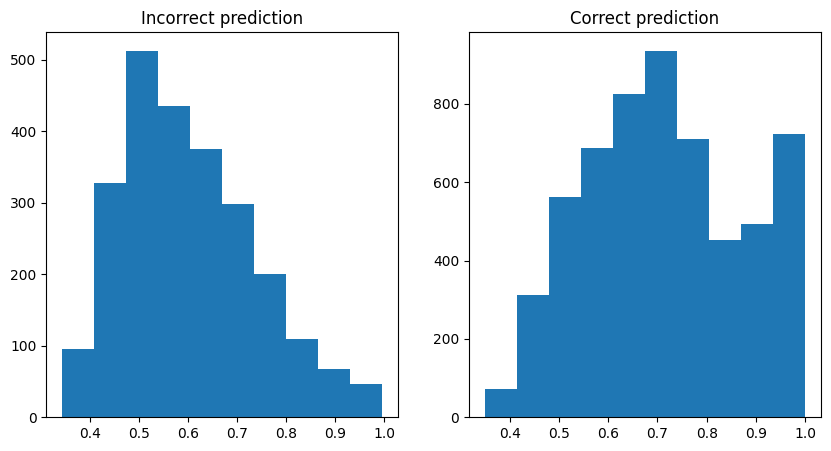

In [64]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model